In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (concatenate, Input, Dense, Dropout, 
                                     BatchNormalization, Flatten, Conv1D, LSTM, 
                                     MaxPooling1D, RepeatVector)
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

#%matplotlib inline

In [2]:
path = '/datasets'

Mounted at /content/drive


Прогнозирование

In [3]:
micro_base = pd.read_csv(path + '/shares_microsoft.csv')

micro_base.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
0,07.04.2021,"249,90","247,83","250,92","247,20","22,72M","0,82%"
1,06.04.2021,"247,86","247,78","249,40","246,90","22,93M","-0,49%"
2,05.04.2021,"249,07","242,90","249,95","242,76","36,91M","2,77%"
3,01.04.2021,"242,35","238,47","242,84","238,05","30,34M","2,79%"
4,31.03.2021,"235,77","232,70","239,00","232,49","43,62M","1,69%"


In [4]:
micro_base = micro_base.sort_index(ascending=False).reset_index(drop=True)
micro_base.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
0,23.05.2001,"34,85","35,20","35,80","34,75","93,66M","-0,88%"
1,24.05.2001,"35,86","34,97","35,89","34,63","80,79M","2,90%"
2,25.05.2001,"35,45","35,83","35,95","35,18","52,76M","-1,14%"
3,29.05.2001,"35,17","35,40","35,88","35,02","71,21M","-0,79%"
4,30.05.2001,"34,59","34,78","35,29","34,33","86,46M","-1,65%"


In [5]:
micro_base['Объём'] = micro_base['Объём'].str.replace('M', '').str.replace(',', '.').astype(float)
micro_base.rename(columns={micro_base.columns[5]: 'Объем млн.'}, inplace=True)
micro_base['Цена'] = micro_base['Цена'].str.replace(',', '.').astype(float)
micro_base['Откр.'] = micro_base['Откр.'].str.replace(',', '.').astype(float)
micro_base['Макс.'] = micro_base['Макс.'].str.replace(',', '.').astype(float)
micro_base['Мин.'] = micro_base['Мин.'].str.replace(',', '.').astype(float)
micro_base['Изм. %'] = micro_base['Изм. %'].str.replace('%', '').str.replace(',', '.').astype(float)

micro_base.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объем млн.,Изм. %
0,23.05.2001,34.85,35.20,35.80,34.75,93.66,-0.88
1,24.05.2001,35.86,34.97,35.89,34.63,80.79,2.90
2,25.05.2001,35.45,35.83,35.95,35.18,52.76,-1.14
3,29.05.2001,35.17,35.40,35.88,35.02,71.21,-0.79
4,30.05.2001,34.59,34.78,35.29,34.33,86.46,-1.65


In [7]:
new_columns = [0, 2, 3, 4, 1, 5, 6]
micro_base = micro_base[micro_base.columns[new_columns]]
micro_base.head()

,Дата,Откр.,Макс.,Мин.,Цена,Объем млн.,Изм. %
0,23.05.2001,35.20,35.80,34.75,34.85,93.66,-0.88
1,24.05.2001,34.97,35.89,34.63,35.86,80.79,2.90
2,25.05.2001,35.83,35.95,35.18,35.45,52.76,-1.14
3,29.05.2001,35.40,35.88,35.02,35.17,71.21,-0.79
4,30.05.2001,34.78,35.29,34.33,34.59,86.46,-1.65


In [8]:
micro_to_np = micro_base.values[2]
micro_to_np

array(['25.05.2001', 35.83, 35.95, 35.18, 35.45, 52.76, -1.14],
      dtype=object)

In [9]:
 data = micro_base.iloc[:,1:-1]
 data = np.array(data)
 data

array([[ 35.2 ,  35.8 ,  34.75,  34.85,  93.66],
       [ 34.97,  35.89,  34.63,  35.86,  80.79],
       [ 35.83,  35.95,  35.18,  35.45,  52.76],
       ...,
       [242.9 , 249.95, 242.76, 249.07,  36.91],
       [247.78, 249.4 , 246.9 , 247.86,  22.93],
       [247.83, 250.92, 247.2 , 249.9 ,  22.72]])

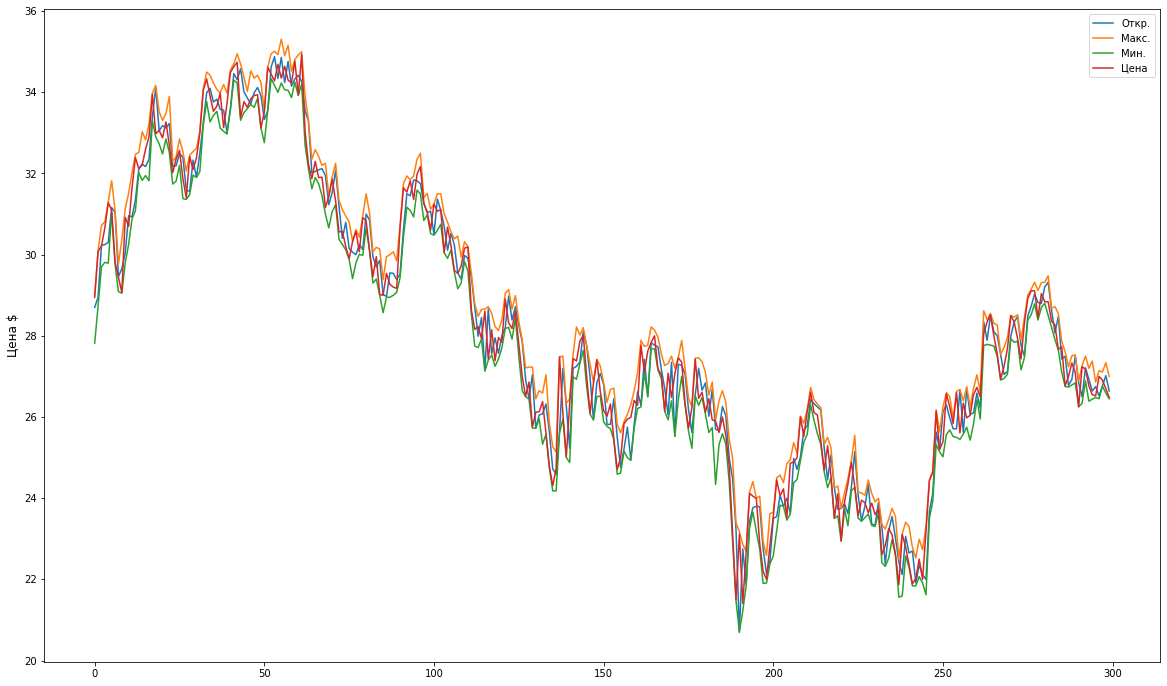

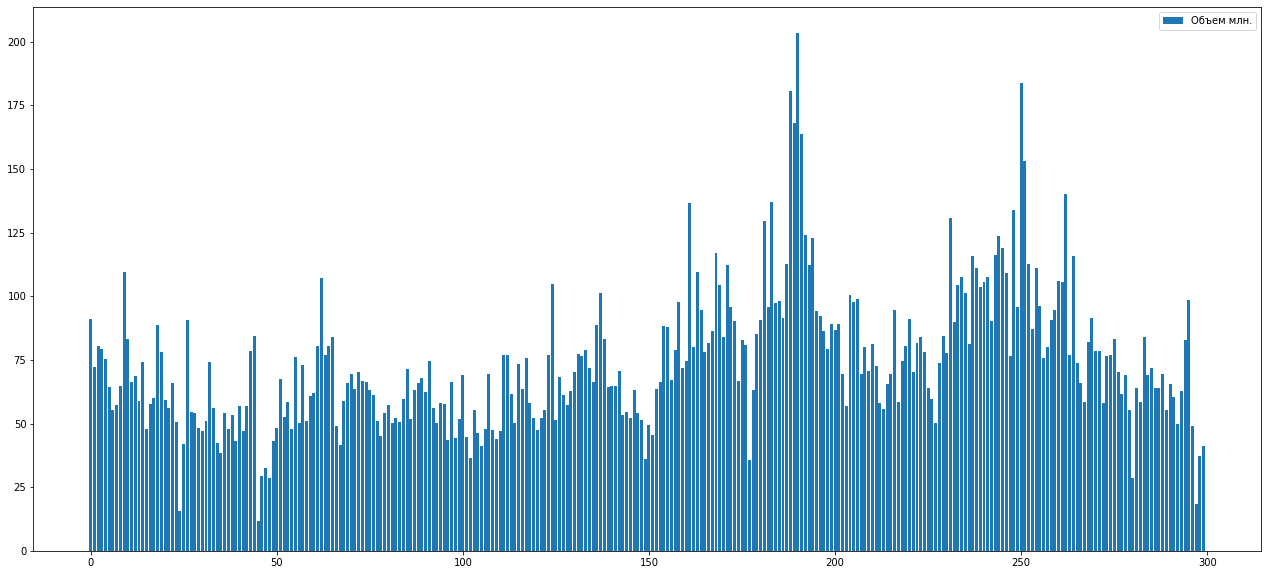

In [11]:
start = 100
length = 300
chanel_names = ['Откр.', 'Макс.', 'Мин.', 'Цена', 'Объем']
plt.figure(figsize=(20, 12))
for i in range(4):
    plt.plot(data[start:start + length, i], label=chanel_names[i])
plt.ylabel('Цена $', fontsize=12)
plt.legend()
plt.show()

plt.figure(figsize=(22,10))
plt.bar(x=np.arange(length), height=data[start:start+length,4], label="Объем млн.")
plt.legend()
plt.show()